# ***Tarea 2.***


1. Selección del conjunto de datos.
2. Método de vectorización.
3. Preprocesamiento: limpieza de texto (remoción de stop words, stemming, etc.), tokenización, y más.
4. Análisis de sentimiento.
5. Reporte.



## **Cargar el conjunto de datos.**

In [3]:
import os
import tarfile
import pandas as pd
import requests
from sklearn.model_selection import train_test_split


In [4]:
# URL del dataset
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset_path = "aclImdb_v1.tar.gz"
extracted_path = "aclImdb"

# Descarga del dataset
if not os.path.exists(dataset_path):
    print("Descargando el dataset... \n")
    response = requests.get(url, stream = True)
    with open(dataset_path, "wb") as file:
        for chunk in response.iter_content(chunk_size = 1024):
            if chunk:
                file.write(chunk)
    print("Descarga completada. \n")

# Descomprimir el archivo
if not os.path.exists(extracted_path):
    print("Descomprimiendo el dataset... \n")
    with tarfile.open(dataset_path, "r:gz") as tar:
        tar.extractall()
    print("Descompresión completada. \n")

# Función para cargar datos
def load_data(data_dir):
    data = []
    labels = []
    for label_type in ["pos", "neg"]:
        dir_name = os.path.join(data_dir, label_type)
        for fname in os.listdir(dir_name):
            if fname.endswith(".txt"):
                with open(os.path.join(dir_name, fname), "r", encoding = "utf-8") as file:
                    data.append(file.read())
                    labels.append(1 if label_type == "pos" else 0)
    return data, labels

# Cargar datos de entrenamiento y prueba
train_data, train_labels = load_data(os.path.join(extracted_path, "train"))
test_data, test_labels = load_data(os.path.join(extracted_path, "test"))

# Crear DataFrames
train_df = pd.DataFrame({"review": train_data, "sentiment": train_labels})
test_df = pd.DataFrame({"review": test_data, "sentiment": test_labels})

# Combinar datos de entrenamiento y prueba 
full_df = pd.concat([train_df, test_df], ignore_index = True)

# Mostrar información del dataset
print(f"Dataset cargado: {len(full_df)} muestras \n")
print(full_df.head())

# Guardar el DataFrame como CSV (opcional)
full_df.to_csv("imdb_reviews.csv", index = False)

# Dividir en entrenamiento y validación
train_df, val_df = train_test_split(train_df, test_size = 0.2, random_state = 42)

print(f"\n Datos de entrenamiento: {len(train_df)} muestras")
print(f"\n Datos de validación: {len(val_df)} muestras \n")


Dataset cargado: 50000 muestras 

                                              review  sentiment
0  For a movie that gets no respect there sure ar...          1
1  Bizarre horror movie filled with famous faces ...          1
2  A solid, if unremarkable film. Matthau, as Ein...          1
3  It's a strange feeling to sit alone in a theat...          1
4  You probably all already know this by now, but...          1

 Datos de entrenamiento: 20000 muestras

 Datos de validación: 5000 muestras 



## **Preprocesamiento y Vectorización**

1. Preprocesamiento:
   - Convertir el texto a minúsculas.
   - Eliminar etiquetas HTML.
   - Filtrar caracteres no alfabéticos.
   - Limpiar espacios extra.  


2. Vectorización:
   - Se utiliza TF-IDF (Term Frequency-Inverse Document Frequency) con un máximo de 5000 características.
   - Filtrar palabras comunes con stop_words = "english".



In [6]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer


In [7]:
# Función de preprocesamiento
def preprocess_text(text):
    
    # Convertir a minúsculas
    text = text.lower()
    
    # Eliminar etiquetas HTML
    text = re.sub(r"<.*?>", "", text)
    
    # Eliminar caracteres no alfanuméricos
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    
    # Eliminar espacios extra
    text = re.sub(r"\s+", " ", text).strip()
    
    return text


In [8]:
# Aplicar preprocesamiento a los datos
train_df["cleaned_review"] = train_df["review"].apply(preprocess_text)
val_df["cleaned_review"] = val_df["review"].apply(preprocess_text)


In [9]:
# Vectorización con TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features = 5000, stop_words = "english")
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["cleaned_review"])
X_val_tfidf = tfidf_vectorizer.transform(val_df["cleaned_review"])


In [10]:
# Convertir etiquetas a formato numérico
y_train = train_df["sentiment"]
y_val = val_df["sentiment"]


In [11]:
# Información sobre los vectores obtenidos
print(f"\n Shape de los vectores de entrenamiento: {X_train_tfidf.shape}")
print(f"\n Shape de los vectores de validación: {X_val_tfidf.shape} \n")



 Shape de los vectores de entrenamiento: (20000, 5000)

 Shape de los vectores de validación: (5000, 5000) 



## **Análisis de sentimientos**

### **Logistic Regression**

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
# Entrenar el modelo
model = LogisticRegression(max_iter = 1000, random_state = 42)
model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [16]:
# Predicciones en el conjunto de validación
y_pred = model.predict(X_val_tfidf)


In [17]:
# Evaluación del modelo
print("Reporte de clasificación para Logistic Regression: \n")
print(classification_report(y_val, y_pred))


Reporte de clasificación para Logistic Regression: 

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      2485
           1       0.86      0.89      0.88      2515

    accuracy                           0.87      5000
   macro avg       0.88      0.87      0.87      5000
weighted avg       0.88      0.87      0.87      5000



In [18]:
# Exactitud del modelo
accuracy = accuracy_score(y_val, y_pred)
print(f"Exactitud en el conjunto de validación: {accuracy:.2f}")


Exactitud en el conjunto de validación: 0.87


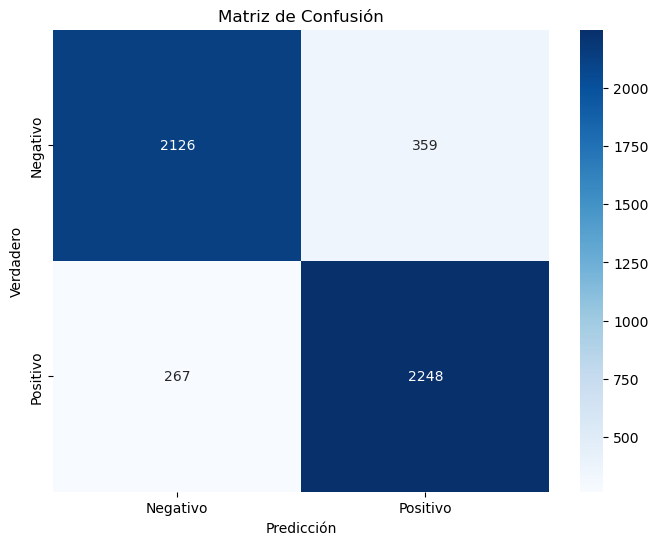

In [19]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues',
            xticklabels = ["Negativo", "Positivo"], yticklabels = ["Negativo", "Positivo"])
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()


### **Support Vector Machines (SVM)**

In [21]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [22]:
# Entrenar el modelo SVM
svm_model = SVC(kernel = "linear", random_state = 42)
svm_model.fit(X_train_tfidf, y_train)


SVC(kernel='linear', random_state=42)

In [23]:
# Predicciones en el conjunto de validación
y_pred_svm = svm_model.predict(X_val_tfidf)


In [24]:
# Evaluación del modelo
print("Reporte de clasificación para SVM: \n")
print(classification_report(y_val, y_pred_svm))


Reporte de clasificación para SVM: 

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2485
           1       0.86      0.89      0.87      2515

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



In [25]:
# Exactitud del modelo
accuracy_svm = accuracy_score(y_val, y_pred_svm)
print(f"Exactitud en el conjunto de validación con SVM: {accuracy_svm:.2f}")


Exactitud en el conjunto de validación con SVM: 0.87


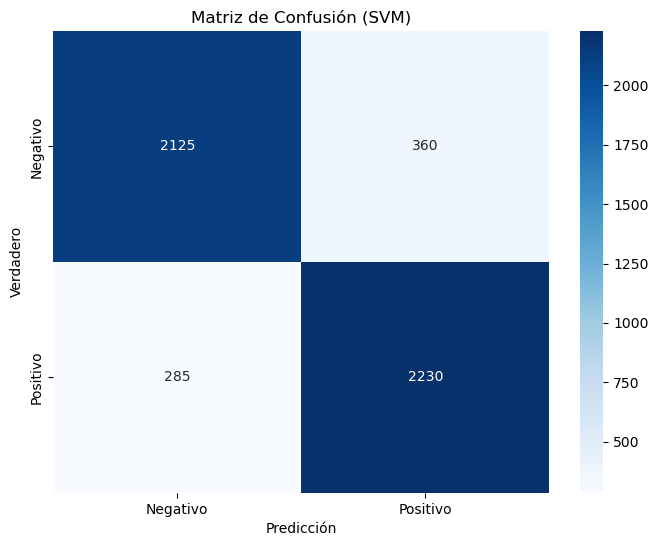

In [26]:
# Matriz de confusión
conf_matrix_svm = confusion_matrix(y_val, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot = True, fmt  ='d', cmap = 'Blues',
            xticklabels = ["Negativo", "Positivo"], yticklabels = ["Negativo", "Positivo"])
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión (SVM)")
plt.show()


### **Random Forest**

In [28]:
from sklearn.ensemble import RandomForestClassifier


In [29]:
# Entrenar el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_model.fit(X_train_tfidf, y_train)


RandomForestClassifier(random_state=42)

In [30]:
# Predicciones en el conjunto de validación
y_pred_rf = rf_model.predict(X_val_tfidf)


In [31]:
# Evaluación del modelo
print("Reporte de clasificación para Random Forest: \n")
print(classification_report(y_val, y_pred_rf))


Reporte de clasificación para Random Forest: 

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      2485
           1       0.85      0.83      0.84      2515

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



In [32]:
# Exactitud del modelo
accuracy_rf = accuracy_score(y_val, y_pred_rf)
print(f"Exactitud en el conjunto de validación con Random Forest: {accuracy_rf:.2f}")


Exactitud en el conjunto de validación con Random Forest: 0.84


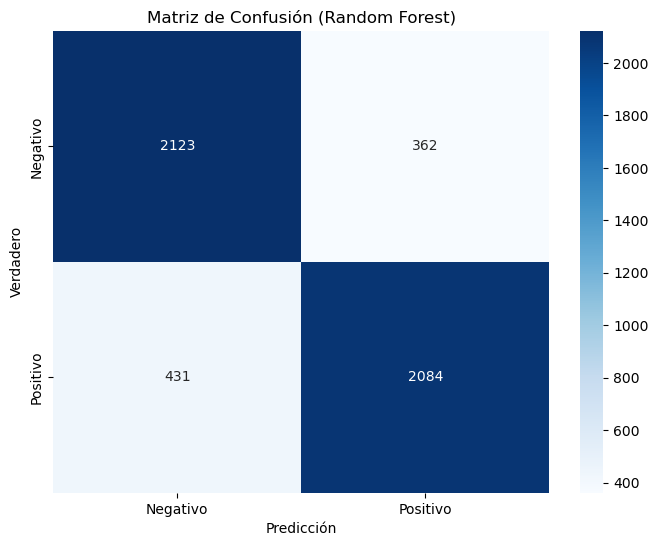

In [33]:
# Matriz de confusión
conf_matrix_rf = confusion_matrix(y_val, y_pred_rf)
plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix_rf, annot = True, fmt = 'd', cmap = 'Blues',
            xticklabels = ["Negativo", "Positivo"], yticklabels = ["Negativo", "Positivo"])
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión (Random Forest)")
plt.show()


### **Comparar resultados**

In [35]:
# Crear un DataFrame para comparar exactitudes
results = {
    "Modelo": ["Logistic Regression", "SVM", "Random Forest"],
    "Exactitud": [accuracy, accuracy_svm, accuracy_rf],
}


In [36]:
results_df = pd.DataFrame(results)

# Mostrar tabla de resultados
print("Comparación de Resultados: \n")
print(results_df)


Comparación de Resultados: 

                Modelo  Exactitud
0  Logistic Regression     0.8748
1                  SVM     0.8710
2        Random Forest     0.8414


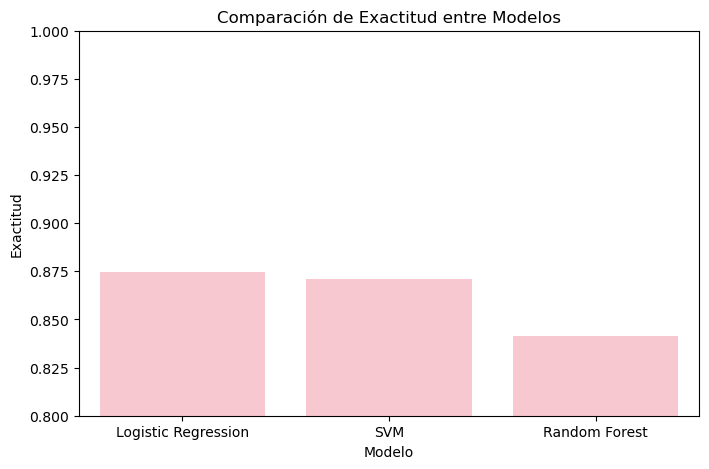

In [45]:
# Gráfica de comparación
plt.figure(figsize = (8, 5))
sns.barplot(x = "Modelo", y = "Exactitud", data = results_df, color = "pink")
plt.title("Comparación de Exactitud entre Modelos")
plt.ylabel("Exactitud")
plt.xlabel("Modelo")
plt.ylim(0.8, 1)  # Ajustar los límites para mejor visualización

# Guardar la gráfica como un archivo PNG
plt.savefig("Comparacion_Modelos.png", dpi = 300)
plt.show()



## Mejor modelo.

- Tanto Logistic Regression como SVM tienen el mismo desempeño global (0.87 de exactitud).
- Si la simplicidad y rapidez son prioritarias, Logistic Regression es la mejor opción.
- Si se busca un modelo más robusto en otras configuraciones, SVM es una excelente elección.


## Recomendación Final.

**Logistic Regression** es la opción recomendada por su balance entre simplicidad, rapidez y desempeño competitivo.

